In [49]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [50]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [7]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Variables, gradients

In [8]:
x = tf.Variable(initial_value=[1.0, 2.0, 3.0, 4.0])

In [12]:
with tf.GradientTape() as g:
    y = tf.reduce_sum(tf.square(x))

In [13]:
g.gradient(y, x)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2., 4., 6., 8.], dtype=float32)>

# CIFAR-10
See https://www.cs.toronto.edu/~kriz/cifar.html

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = tf.cast(x_train, tf.float32) / 255
x_test = tf.cast(x_test, tf.float32) / 255
y_train = tf.squeeze(tf.cast(y_train, tf.int32))
y_test = tf.squeeze(tf.cast(y_test, tf.int32))

170500096/170498071 [==============================] - 3s 0us/step


In [15]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

'automobile'

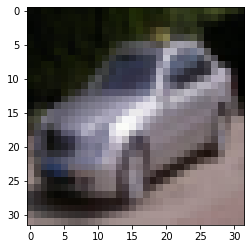

In [16]:
img_number =  5102#@param {type:"integer"}

plt.imshow(np.squeeze(x_train[img_number]))
labels[y_train[img_number]]

# Low-level tensorflow without keras

## 2-layer convolutional network / ResNet

In [25]:
class CifarCNN(tf.Module):
    def __init__(self):
        initializer = tf.keras.initializers.glorot_normal()
        self._filter1 = tf.Variable(initializer([3, 3, 3, 8]))
        self._filter2 = tf.Variable(initializer([3, 3, 8, 5]))
        self._filter_project = tf.Variable(initializer([1, 1, 8, 5]))
        self._fcn_weights = tf.Variable(
            initializer([16 * 16 * 5, 10])
    )

    @tf.function(input_signature=[tf.TensorSpec([None, 32, 32, 3])])
    def Infer(self, input_batch):

        # input_batch is (batch_size x 32 x 32 x 3)
        net = tf.nn.conv2d(input_batch, self._filter1, strides=[1,1], padding="SAME")
        net = tf.nn.relu(net)
        net = tf.nn.max_pool2d(net, ksize=[2, 2], strides=[2, 2], padding="SAME")
        residuals = tf.nn.relu(tf.nn.conv2d(
            net, self._filter2, strides=[1,1], padding="SAME"))
        net = residuals + tf.nn.conv2d(
            net, self._filter_project, strides=[1,1], padding="SAME")
        net = tf.reshape(net, [tf.shape(net)[0], -1])
        net = tf.matmul(net, self._fcn_weights)
        
        return net

    def GetLoss(self, x_batch, y_batch):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
              tf.squeeze(y_batch),
              self.Infer(x_batch))
        return tf.reduce_mean(losses)

    def Accuracy(self, x, y_true):
        logits = self.Infer(x)
        return tf.reduce_mean(
            tf.cast(tf.math.equal(
                tf.cast(tf.math.argmax(logits, 1), y_true.dtype), 
                y_true), tf.float32))

    @tf.function
    def MakeStep(self, x_batch, y_batch, optimizer):
        with tf.GradientTape() as g:
            loss = self.GetLoss(x_batch, y_batch)
        g = g.gradient(loss, self.trainable_variables)

        # SGD step
        optimizer.apply_gradients(zip(g, self.trainable_variables))

In [26]:
cnn = CifarCNN()

In [27]:
cnn.Accuracy(x_test, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0936>

In [28]:
batch_size = 10
epochs = 5

optimizer = tf.keras.optimizers.Adam()
_ = cnn.Infer(x_train[0:10])
for j in range(epochs):
    print(f"Epoch {j}: test accuracy {cnn.Accuracy(x_test, y_test)}")
    for i in range(5000):
        cnn.MakeStep(
            x_train[(i*batch_size):((i+1)*batch_size)],
            y_train[(i*batch_size):((i+1)*batch_size)],
            optimizer)

Epoch 0: test accuracy 0.09359999746084213
Epoch 1: test accuracy 0.48339998722076416
Epoch 2: test accuracy 0.527899980545044
Epoch 3: test accuracy 0.5414999723434448
Epoch 4: test accuracy 0.5516999959945679


# Keras sequential API

See https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [30]:
logdir="logs/sequential_fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
model.fit(x_train, 
          y_train,
          batch_size=10,
          epochs=3,
          verbose=1,
          validation_data=(
              x_test, 
              y_test),
          callbacks=[tensorboard_callback],
         use_multiprocessing=False)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 310us/sample - loss: 1.1306 - accuracy: 0.6042 - val_loss: 1.2404 - val_accuracy: 0.5653
Epoch 2/3
50000/50000 [==============================] - 21s 428us/sample - loss: 1.1220 - accuracy: 0.6064 - val_loss: 1.2016 - val_accuracy: 0.5768
Epoch 3/3
50000/50000 [==============================] - 15s 293us/sample - loss: 1.1126 - accuracy: 0.6114 - val_loss: 1.1992 - val_accuracy: 0.5814


In [32]:
%tensorboard --logdir logs

# Keras functional API

See https://www.tensorflow.org/guide/keras/functional

In [33]:
inputs = tf.keras.layers.Input(shape=[32, 32, 3])
layer1 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding="same")(inputs)
layer2 = tf.keras.layers.MaxPool2D(strides=2)(layer1)
layer3_resid = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu', padding="same")(layer2)
layer2_proj = tf.keras.layers.Conv2D(filters=5, kernel_size=1, padding="same")(layer2)
layer3 = layer2_proj + layer3_resid
layer4 = tf.keras.layers.Flatten()(layer3)
layer5 = tf.keras.layers.Dense(10, activation='softmax')(layer4)

In [34]:
model = tf.keras.Model(inputs=inputs, outputs=layer5)

In [35]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
model.fit(x_train, 
          y_train,
          batch_size=10,
          epochs=5,
          verbose=1,
          validation_data=(
              x_test, 
              y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 24s 488us/sample - loss: 1.5520 - accuracy: 0.4491 - val_loss: 1.3702 - val_accuracy: 0.5155
Epoch 2/5
50000/50000 [==============================] - 26s 524us/sample - loss: 1.3265 - accuracy: 0.5344 - val_loss: 1.3165 - val_accuracy: 0.5332
Epoch 3/5
50000/50000 [==============================] - 25s 494us/sample - loss: 1.2634 - accuracy: 0.5575 - val_loss: 1.2716 - val_accuracy: 0.5477
Epoch 4/5
50000/50000 [==============================] - 23s 456us/sample - loss: 1.2273 - accuracy: 0.5699 - val_loss: 1.2726 - val_accuracy: 0.5575
Epoch 5/5
50000/50000 [==============================] - 23s 457us/sample - loss: 1.1953 - accuracy: 0.5805 - val_loss: 1.2274 - val_accuracy: 0.5660


# Subclassing Keras layer

See https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [38]:
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ResidualLayer, self).__init__()
        self._conv = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu', padding='same')
        self._project = tf.keras.layers.Conv2D(filters=5, kernel_size=1, padding='same')

    def call(self, inputs):
        return self._project(inputs) + self._conv(inputs)

In [40]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(ResidualLayer())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [41]:
model.fit(x_train, 
          y_train,
          batch_size=10,
          epochs=5,
          verbose=1,
          validation_data=(
              x_test, 
              y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 18s 355us/sample - loss: 1.5635 - accuracy: 0.4429 - val_loss: 1.4315 - val_accuracy: 0.4890
Epoch 2/5
50000/50000 [==============================] - 18s 357us/sample - loss: 1.3658 - accuracy: 0.5182 - val_loss: 1.3334 - val_accuracy: 0.5256
Epoch 3/5
50000/50000 [==============================] - 14s 278us/sample - loss: 1.2894 - accuracy: 0.5465 - val_loss: 1.3289 - val_accuracy: 0.5240
Epoch 4/5
50000/50000 [==============================] - 17s 338us/sample - loss: 1.2402 - accuracy: 0.5636 - val_loss: 1.2773 - val_accuracy: 0.5475
Epoch 5/5
50000/50000 [==============================] - 15s 295us/sample - loss: 1.2063 - accuracy: 0.5767 - val_loss: 1.2721 - val_accuracy: 0.5488


# Saving models

See https://www.tensorflow.org/guide/keras/save_and_serialize

## Keras model

In [42]:
model.save("models/sequential")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/sequential/assets


In [43]:
restored_sequential_model = tf.keras.models.load_model("models/sequential")

In [44]:
type(restored_sequential_model)

tensorflow.python.keras.saving.saved_model.load.Sequential

## Custom model

In [45]:
tf.saved_model.save(
    cnn, 
    "models/custom_cnn",
    signatures=cnn.Infer)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name='x_batch'), TensorSpec(shape=(10,), dtype=tf.int32, name='y_batch'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x639bc6cd0>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name='x_batch'), TensorSpec(shape=(10,), dtype=tf.int32, name='y_batch'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x13261d9d0>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name='x_batch'), TensorSpec(shape=(10,), dtype=tf.int32, name='y_batch'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x639bc6cd0>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name='x_batch'), TensorSpec(shape=(10,), dtype=tf.int32, name='y_batch'), <t

In [46]:
restored_custom_cnn = tf.saved_model.load("models/custom_cnn")

In [47]:
type(restored_custom_cnn)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [48]:
restored_custom_cnn.Infer(x_train)

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[-5.4295797e+00, -2.9956594e+00, -6.0062349e-02, ...,
         1.6884594e+00, -4.6028161e+00, -1.9677858e+00],
       [-1.5982915e+00,  1.4999268e+00, -7.4555182e-01, ...,
         1.5438454e+00, -6.4828980e-01,  2.8782196e+00],
       [-5.9725356e-01,  6.5766191e-01, -2.4925237e+00, ...,
        -1.3512856e+00,  3.5838175e-01,  2.3083820e+00],
       ...,
       [ 1.4636739e+00,  1.4987171e-01, -1.5574808e+00, ...,
        -8.5774601e-02,  1.6649008e-01,  3.6600404e+00],
       [ 9.9532920e-01,  3.8263810e+00, -9.1854852e-01, ...,
        -3.1637583e+00,  2.0755935e+00,  3.5024641e+00],
       [-2.2651553e-03,  1.6006379e+00, -1.3870288e+00, ...,
        -1.2022585e+00,  1.6045918e+00,  1.2374460e+00]], dtype=float32)>